# Run WOFOST phenology model

In [92]:
%matplotlib inline
import sys, os
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt
import pandas as pd
import pcse
import xarray as xr
import numpy as np
#import sklearn


    
def read_data_Fossati(variety):
    
    """ Read data from Dario Fossati for further use for certain variety. 
    - Change "Harvestyear" to "year"
    
    """
    
    ###### Dario Fossati data
    
    # read phenology data for wheat
    datadir = 'C:/Users/F80840370/projects/scClim/climada/data/scClim/exposure/phenology/Fossati_Agroscope/Phenologie_Fossati_put_together_00_18.csv'
    data_Fossati = pd.read_csv(datadir, delimiter=';', header=0, encoding="ISO-8859-1")
    # rename
    data_Fossati = data_Fossati.rename(columns={"Harvestyear": "year"})

    pheno_calib=data_Fossati.loc[(data_Fossati['Variety']==variety) & (data_Fossati['Heading'].isnull().values==False) & (data_Fossati['PLZ']!=1896)]

    return pheno_calib

def load_mch_data(startyear,endyear):

    startyear = int(startyear)
    endyear = int(endyear)
    
    datadir='O:/Data-Raw/27_Natural_Resources-RE/99_Meteo_Public/MeteoSwiss_netCDF/__griddedData/lv95/'
    
    ds_dict={}
    for var in ['Tmax','Tmin']:
   
        #get list of datafiles #1961-2022
        datafiles=[datadir+str(var)+'D_ch01r.swiss.lv95_'+str(year)+'01010000_'+str(year)+'12310000.nc' for year in range(startyear,endyear+1)]
        #read datafiles
        print('reading data from {}...'.format(datadir))
        ds_dict[var]=xr.open_mfdataset(datafiles,concat_dim = 'time',combine='nested',coords = 'minimal')
  
    return ds_dict
        
class wdp_from_MCH(pcse.base.WeatherDataProvider):
 
    def __init__(self, default_values,data_mch,elevation, start_day, end_day):
        super().__init__()
        
        lon=data_mch.lon.values
        lat=data_mch.lat.values
        
        self.elevation = elevation
        self.longitude = lon
        self.latitude = lat
 
        for d in pd.date_range(start_day, end_day):
            d1 = d.date()
            tmin=data_mch.TminD.sel(time=d).values
            tmax=data_mch.TmaxD.sel(time=d).values
            wdc = pcse.base.WeatherDataContainer(DAY=d1, LAT=lat, LON=lon, ELEV=elevation,TMIN=tmin,TMAX=tmax,
                                                 **default_values)
            self._store_WeatherDataContainer(wdc, d1)
 
 
def get_agromanagement_wheat(year):
    
        year=year-1
        import yaml
        from yaml import CLoader as Loader, CDumper as Dumper
        import datetime
        txt=open(data_dir+'/agro/'+'wheat_calendar.txt')
        yaml_agro=yaml.load(txt,Loader=Loader)
        #create start dates
        standard_date=list(yaml_agro['AgroManagement'][0].keys())[0]
        campaign_date=datetime.date(year,10,1)
        crop_start_date=datetime.date(year,10,15)

        #get campaign and replace dates
        yaml_agro['AgroManagement'][0][campaign_date]=yaml_agro['AgroManagement'][0].pop(standard_date)
        yaml_agro['AgroManagement'][0][campaign_date]['CropCalendar']['crop_start_date']=crop_start_date
        
        agromanager=yaml_agro #pcse.agromanager.AgroManager.initialize(yaml_agro)

        return agromanager


def rmse(params,wdp_dict,agro_dict, DOY_obs_dict):
    
    """
    Compute Root mean squared error of modeled Heading DOY based WOFOST and observed DOY
    
    Parameters
    ----------
    params: list
        list of parameters, here only TSUM1
    Teffs: dict of pd.Dataframes
        dictionary with years as keys and dataframe as entries, with columns "TEFF" containing effective temperatures and "DOY" containing the day of the year
    DOY_obs_dict: dict
        dictionary with years as keys and observed heading DOY as entries

    Returns
    ---------
        RMSE: float
            Root mean squared error of modeled Heading DOY and observed heading DOY.
    """
   
    #from sklearn.metrics import mean_squared_error
    import math 
    
    #prepare list of simulated and modeled values
    DOY_sim=[]
    DOY_obs=[]
    
    #loop over years and locations (keys)
    for key in DOY_obs_dict.keys():
            plz=int(key[0:4])
            year=int(key[5:9])
            if year>=2001:
                #model heading DOY based on growing degree days (GDD_model)
                DOY=WOFOST_model(wdp_dict[plz],agro_dict[year],params)

                #append to lists
                DOY_sim.append(DOY)
                DOY_obs.append(DOY_obs_dict[key])

    #compute root mean squared error
    MSE = np.square(np.subtract(DOY_obs,DOY_sim)).mean() 
    #MSE = mean_squared_error(DOY_obs, DOY_sim)
    RMSE = math.sqrt(MSE)
    
    print(RMSE)
    return RMSE

def WOFOST_model(wdp,agro,params):

    from pcse.base import ParameterProvider
    from pcse.models import Wofost72_Phenology
    
    #CROPDATA
    from pcse.fileinput import YAMLCropDataProvider
    cropd=YAMLCropDataProvider(repository="https://raw.githubusercontent.com/ajwdewit/WOFOST_crop_parameters/master/")
    #cropd.print_crops_varieties()
    #Region:  Central Germany, northern France
    cropd.set_active_crop('wheat','Winter_wheat_105')
    cropdata=cropd.copy()
    #set parameters from Ryan Conway
    cropdata['TSUM1'] = params[0] #974.     #! temperature sum from emergence to anthesis [cel d]
    cropdata['TSUM2'] = 1012.    #! temperature sum from anthesis to maturity [cel d]
    parameters = ParameterProvider(cropdata=cropdata)

    #run simulation 
    wofsim = Wofost72_Phenology(parameters, wdp, agro)
    wofsim.run_till_terminate()
    df_results = pd.DataFrame(wofsim.get_output())
    df_results = df_results.set_index("day")
    date_sim=df_results[df_results['DVS']==1].index.values[0]
    DOY_sim=pd.to_datetime(date_sim).dayofyear

    return DOY_sim

#%% Calibration
def prep_data_for_calib(pheno_calib):
    
    """
    Prepare meteodata and phenological data to use for optimization model    
    
    Parameters
    ----------
    pheno_calib: pandas.Dataframe
        Dataframe with obs data: required columns are 'year' and 'Heading' 

    Returns
    ---------
    DOY_obs_dict: dict
            dictionary with PLZs_years as keys and observed heading DOY as entries
            
    """
    #years for which phenological data is available
    years=np.unique(pheno_calib['year'].values)
    
    #prepare output ddicts
    DOY_obs_dict={}                         

    for year in years:
        for PLZ in list(set(pheno_calib['PLZ'])):
            
  
            #get observed heading date (mean if several data with same year)
            doy_obs=pheno_calib.loc[(pheno_calib['year']==year) & (pheno_calib['PLZ']==PLZ)]['Heading'].mean()
     
            if np.isnan(doy_obs)!=True:
                
                #fill data
                key=str(PLZ)+'_'+str(year)
                DOY_obs_dict[key]=doy_obs
            
    
    return DOY_obs_dict


In [39]:
defaults = {"IRRAD": 20e6,
            "VAP": 5,
            "RAIN": 2,
            "E0": 0.5,
            "ES0": 0.5,
            "ET0": 0.5,
            "WIND": 10,
            "SNOWDEPTH": 0}

#read data Fossati
variety='ARINA'
pheno_calib=read_data_Fossati(variety)
DOY_obs_dict=prep_data_for_calib(pheno_calib)
#get plzs and MCH data
startyear=2000
endyear=2021
variables=['Tmin','Tmax']
filename_base='TminTmax_daily_{}_{}'.format(startyear,endyear)

data_mch_plz={}
wdp_dict = {}
plzs=list(set(data_Fossati['PLZ']))
for PLZ in plzs:
    datadir='C:/Users/F80840370/projects/scClim/climada/data/scClim/exposure/phenology/TminTmax/'
    data_mch_plz[PLZ]=xr.open_dataset(datadir+filename_base+'_{}.nc'.format(PLZ))
    wdp_dict[PLZ] = wdp_from_MCH(defaults, data_mch_plz[PLZ], elevation=500,start_day="2000-01-01", end_day="2021-12-31")

print(wdp_dict)
print('bla')

{1376: <__main__.wdp_from_MCH object at 0x000001E983828400>, 3428: <__main__.wdp_from_MCH object at 0x000001E98418DB50>, 5444: <__main__.wdp_from_MCH object at 0x000001E98418DE80>, 1510: <__main__.wdp_from_MCH object at 0x000001E98418F9D0>, 1260: <__main__.wdp_from_MCH object at 0x000001E9841E2340>, 3052: <__main__.wdp_from_MCH object at 0x000001E9841E2EE0>, 8046: <__main__.wdp_from_MCH object at 0x000001E983DA52E0>, 1042: <__main__.wdp_from_MCH object at 0x000001E984686D30>, 8052: <__main__.wdp_from_MCH object at 0x000001E984686F40>, 8566: <__main__.wdp_from_MCH object at 0x000001E984ADE970>, 8315: <__main__.wdp_from_MCH object at 0x000001E985D4AF40>, 1725: <__main__.wdp_from_MCH object at 0x000001E981BC3160>, 4702: <__main__.wdp_from_MCH object at 0x000001E981BCCA30>, 1567: <__main__.wdp_from_MCH object at 0x000001E981BCCE50>}
bla


In [66]:
variety='ARINA'
data_Fossati=read_data_Fossati(variety)

data_dir = os.path.join(os.getcwd(), "data")


print("This notebook was built with:")
print("python version: %s " % sys.version)
print("PCSE version: %s" %  pcse.__version__)


#AGROMANAGEMENT
agro_dict={}
for year in range(2001,2022):
    print(year)
    from pcse.fileinput import YAMLAgroManagementReader
    #agromanagement_file = os.path.join(data_dir, 'agro', 'wheat_calendar.txt')
    #agromanagement = YAMLAgroManagementReader(agromanagement_file)
    #print(agromanagement)
    agro_dict[year]=get_agromanagement_wheat(year)

#DAILY WEATHER OBS
from pcse.db import NASAPowerWeatherDataProvider
#wdp = wdp_dict[PLZ]
#from pcse.fileinput import ExcelWeatherDataProvider
#weatherfile = os.path.join(data_dir, 'meteo', 'nl1.xls')
#wdp = ExcelWeatherDataProvider(weatherfile)

#from pcse.base import ParameterProvider
#parameters = ParameterProvider(cropdata=cropd)
#print(wdp)



This notebook was built with:
python version: 3.8.13 (default, Mar 28 2022, 06:59:08) [MSC v.1916 64 bit (AMD64)] 
PCSE version: 5.5.3
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


In [96]:
#run calibratin/optimization
from scipy.optimize import minimize
TSUM1_0=980
result=minimize(rmse,[TSUM1_0,],args=(wdp_dict,agro_dict,DOY_obs_dict),tol=1e-3, method="Powell")
print(result) 

11.757860573903596
10.239750718898442
11.04869285156229
9.788164722044828
9.511194837013765
9.375257544575028
9.208062556732004
9.140441810999556
9.104940016233838
9.09062189200644
9.056751704856811
9.037693426854704
9.037693426854704
9.037693426854704
9.037693426854704
9.037693426854704
9.037693426854704
9.037693426854704
9.037693426854704
9.037693426854704
9.037693426854704
9.037693426854704
9.037693426854704
9.037693426854704
9.026882671741761
11.04869285156229
10.239750718898442
9.788164722044828
9.511194837013765
9.375257544575028
9.208062556732004
9.140441810999556
9.104940016233838
9.09062189200644
9.056751704856811
9.037693426854704
9.037693426854704
9.037693426854704
9.037693426854704
9.037693426854704
10.239750718898442
11.04869285156229
9.788164722044828
9.511194837013765
9.375257544575028
9.208062556732004
9.140441810999556
9.104940016233838
9.09062189200644
9.056751704856811
9.037693426854704
9.037693426854704
9.037693426854704
9.037693426854704
9.037693426854704
9.0376934

In [94]:
err=rmse([1010,],wdp_dict,agro_dict, DOY_obs_dict)
print(err)
#1002

11.757860573903596
11.757860573903596


In [87]:
cropd

{'CO2EFFTB': [40.0, 0.0, 360.0, 1.0, 720.0, 1.11, 1000.0, 1.11, 2000.0, 1.11],
 'CO2TRATB': [40.0, 0.0, 360.0, 1.0, 720.0, 0.9, 1000.0, 0.9, 2000.0, 0.9],
 'CO2AMAXTB': [40.0, 0.0, 360.0, 1.0, 720.0, 1.6, 1000.0, 1.9, 2000.0, 1.9],
 'TBASEM': 0.0,
 'TEFFMX': 30.0,
 'TSUMEM': 120,
 'IDSL': 2,
 'DLO': 15.3,
 'DLC': 8.0,
 'TSUM1': 706,
 'TSUM2': 975,
 'DTSMTB': [0.0, 0.0, 30.0, 30.0, 45.0, 30.0],
 'DVSI': 0.0,
 'DVSEND': 2.0,
 'VERNBASE': 7.0,
 'VERNSAT': 37.0,
 'VERNDVS': 0.3,
 'VERNRTB': [-8.0, 0.0, -4.0, 0.0, 3.0, 1.0, 10.0, 1.0, 17.0, 0.0, 20.0, 0.0],
 'TDWI': 50.0,
 'RGRLAI': 0.0082,
 'SLATB': [0.0, 0.00212, 0.5, 0.00212, 2.0, 0.00212],
 'SPA': 0.0,
 'SSATB': [0.0, 0.0, 2.0, 0.0],
 'SPAN': 31.3,
 'TBASE': 0.0,
 'KDIFTB': [0.0, 0.6, 2.0, 0.6],
 'EFFTB': [0.0, 0.45, 40.0, 0.45],
 'AMAXTB': [0.0, 35.83, 1.0, 35.83, 1.3, 35.83, 2.0, 4.48],
 'TMPFTB': [0.0, 0.01, 10.0, 0.6, 15.0, 1.0, 25.0, 1.0, 35.0, 0.0],
 'TMNFTB': [0.0, 0.0, 3.0, 1.0],
 'CVL': 0.685,
 'CVO': 0.709,
 'CVR': 0.694,
 'CV

In [19]:
from pcse.base import ParameterProvider
from pcse.models import Wofost72_Phenology

DOY_sim_dict={}
years=range(2001,2021)
for PLZ in plzs:
        print(PLZ)
        DOY_sims=[]
        for year in years:
            wofsim = Wofost72_Phenology(parameters, wdp_dict[PLZ], agro_dict[year])
            wofsim.run_till_terminate()
            df_results = pd.DataFrame(wofsim.get_output())
            df_results = df_results.set_index("day")
            df_results.tail()
            DOY_sims.append(df_results[df_results['DVS']==1].index.values[0])

        DOY_sim_dict[PLZ]=pd.DataFrame({'years':years, 'DOY_sim': DOY_sims})

print(DOY_sim_dict)

1376


NameError: name 'parameters' is not defined

In [11]:
import pickle
pheno_datadir='C:/Users/F80840370/projects/scClim/wofost/PhenoSwiss/data/output/DOY_sim/'

with open(pheno_datadir+'DOY_sim_ARINA.p', 'wb') as handle:
    pickle.dump(DOY_sim_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
print(df_results[df_results['DVS']==1].index.values)



[datetime.date(2020, 5, 11)]


Now, just run the phenology module. For that, need to specify parameters

- crop parameters consist of parameter names and the corresponding parameter values that are needed to parameterize the components of the crop simulation model. They can be downloaded here 
https://raw.githubusercontent.com/ajwdewit/WOFOST_crop_parameters/master/. 

- Agromanagement
These parameters characterize the crop calendar and events (such as, e.g. irrigation). For the most basic set up, only crop calender is needed

- Weather data
daily weather data 




In [64]:
print(PLZ)
wdp.description
dir(wdp)
from datetime import date
day = date(2021,7,3)
wdc = wdp(day)
print(wdc)

1260
Weather data for 2021-07-03 (DAY)
IRRAD:  20000000.00  J/m2/day
 TMIN:        14.36   Celsius
 TMAX:        19.98   Celsius
  VAP:         5.00       hPa
 RAIN:         2.00    cm/day
   E0:         0.50    cm/day
  ES0:         0.50    cm/day
  ET0:         0.50    cm/day
 WIND:        10.00     m/sec
SNOWDEPTH:         0.00        cm
Latitude  (LAT):    46.38 degr.
Longitude (LON):     6.22 degr.
Elevation (ELEV):  500.0 m.



In [65]:
from pcse.base import ParameterProvider
parameters = ParameterProvider(cropdata=cropd)

In [66]:
from pcse.models import Wofost72_Phenology
wofsim = Wofost72_Phenology(parameters, wdp, agromanagement)

In [67]:
wofsim.run_till_terminate()
df_results = pd.DataFrame(wofsim.get_output())
df_results = df_results.set_index("day")
df_results.tail()

,DVS,TSUM,TSUME,VERN
day,,,,
2001-07-09,1.920876,1593.234348,120.626083,41.618218
2001-07-10,1.941393,1612.725166,120.626083,41.618218
2001-07-11,1.962958,1633.212114,120.626083,41.618218
2001-07-12,1.981219,1650.559891,120.626083,41.618218
2001-07-13,2.000000,1668.581099,120.626083,41.618218


            DVS        TSUM       TSUME       VERN
day                                               
2001-05-21  1.0  718.401754  120.626083  41.618218


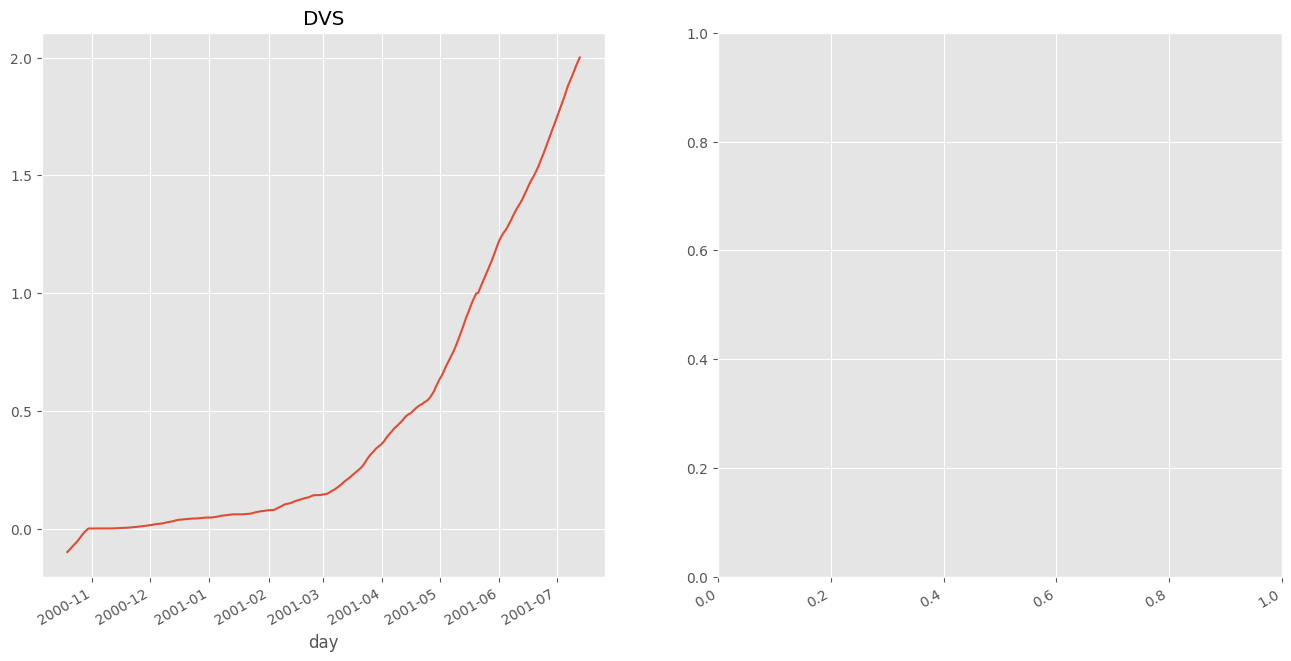

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
df_results['DVS'].plot(ax=axes[0], title="DVS")
print(df_results[df_results['DVS']==1])

#df['SM'].plot(ax=axes[1], title="Root zone soil moisture")
fig.autofmt_xdate()